In [ ]:
! pip install -q kaggle

from google.colab import files 

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"avanipathak","key":"b4e861ab2cf58665c166e40614636257"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

! unzip face-expression-recognition-dataset.zip -d img

Streaming output truncated to the last 5000 lines.
  inflating: img/images/validation/fear/8797.jpg  
  inflating: img/images/validation/fear/8818.jpg  
  inflating: img/images/validation/fear/886.jpg  
  inflating: img/images/validation/fear/9037.jpg  
  inflating: img/images/validation/fear/9040.jpg  
  inflating: img/images/validation/fear/9101.jpg  
  inflating: img/images/validation/fear/911.jpg  
  inflating: img/images/validation/fear/9179.jpg  
  inflating: img/images/validation/fear/9205.jpg  
  inflating: img/images/validation/fear/9232.jpg  
  inflating: img/images/validation/fear/9251.jpg  
  inflating: img/images/validation/fear/9261.jpg  
  inflating: img/images/validation/fear/9281.jpg  
  inflating: img/images/validation/fear/9302.jpg  
  inflating: img/images/validation/fear/9333.jpg  
  inflating: img/images/validation/fear/9369.jpg  
  inflating: img/images/validation/fear/9370.jpg  
  inflating: img/images/validation/fear/9474.jpg  
  inflating: img/images/validatio

## Load our dataset
#### Display some images from our dataset
#### Dataset contain images from seven different Categories

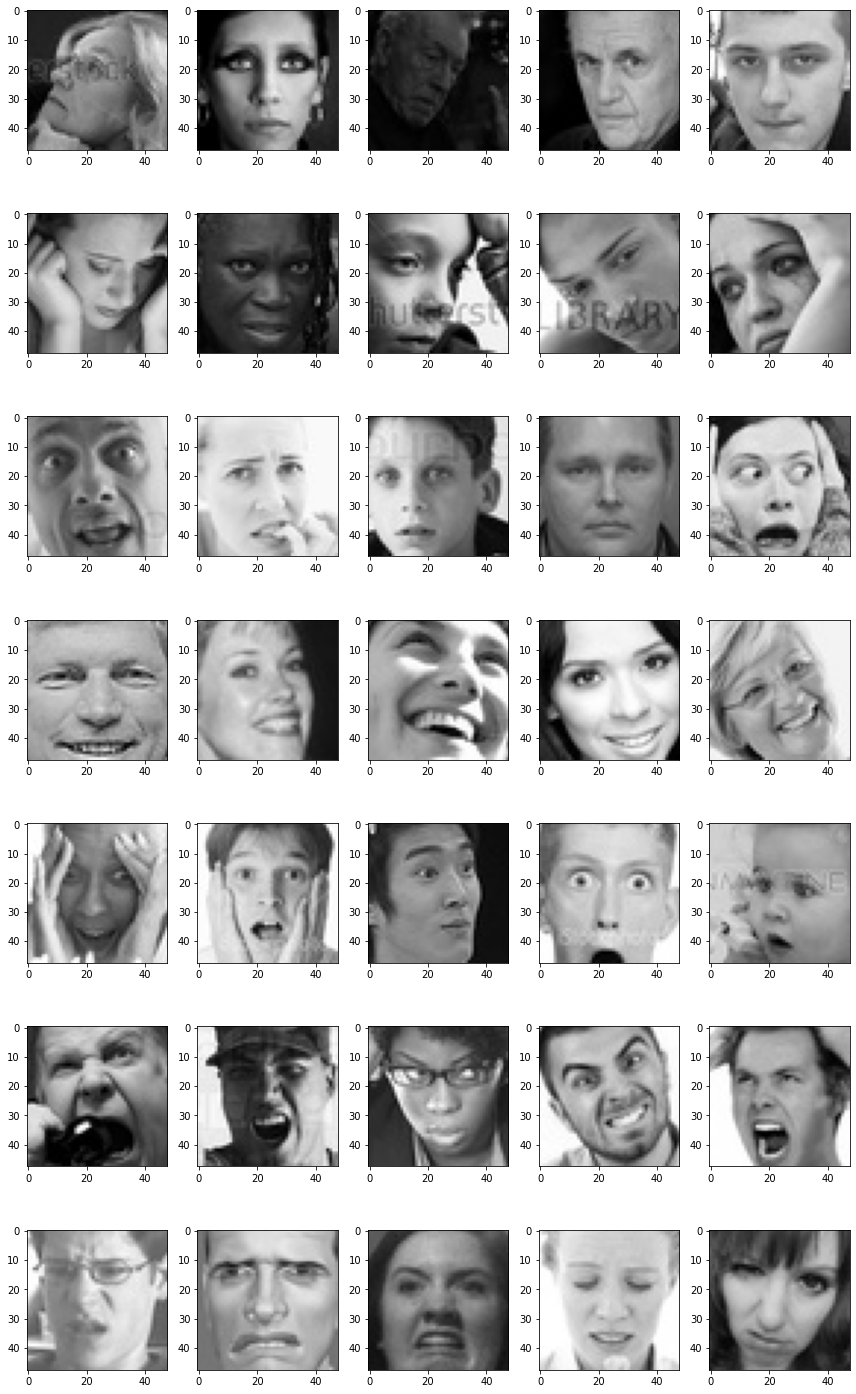

In [ ]:
# display some images for every different expression

import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# size of the image: 48*48 pixels
pic_size = 48

# input path for the images
base_path = "/content/img/images/"
#../input/face-expression-recognition-dataset/images/
plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

## Image augmentation using keras ImageDataGenerator

In [ ]:
# building data generator 

from keras.preprocessing.image import ImageDataGenerator

batch_size = 128
base_path = "/content/img/images/"

#../input/face-expression-recognition-dataset/images/
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 20,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale= 1.0/255)

train_generator = train_datagen.flow_from_directory(base_path + "train",
                                                    target_size=(56,56),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(base_path + "validation",
                                                    target_size=(56,56),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Defining our 4 Convolution and 2 Dense layers model

In [ ]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(56, 56,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

print(model.summary())

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 56, 56, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       5

In [ ]:
%%time

# number of epochs to train the NN
epochs = 50

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 1.5312 - accuracy: 0.4041
Epoch 00001: val_accuracy improved from -inf to 0.40909, saving model to model_weights.h5
225/225 [==============================] - 23s 103ms/step - loss: 1.5312 - accuracy: 0.4041 - val_loss: 1.6788 - val_accuracy: 0.4091
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 1.5010 - accuracy: 0.4180
Epoch 00002: val_accuracy improved from 0.40909 to 0.47088, saving model to model_weights.h5
225/225 [==============================] - 23s 104ms/step - loss: 1.5010 - accuracy: 0.4180 - val_loss: 1.3944 - val_accuracy: 0.4709
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 1.4630 - accuracy: 0.4351
Epoch 00003: val_accuracy improved from 0.47088 to 0.48565, saving model to model_weights.h5
225/225 [==============================] - 23s 103ms/step - loss: 1.4630 - accuracy: 0.4351 - val_loss: 1.3474 - val_accuracy: 0.4857
Epoch 4/50
225/225 [==============

In [ ]:
model.save("/content")

INFO:tensorflow:Assets written to: /content/assets


In [ ]:
import os
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image

model_json = model.to_json()
with open("/content/model.json", "w") as json_file:
  json_file.write(model_json)
model.save_weights("/content/model.h5")
print("Saved model to disk")


Saved model to disk


## Connecting with openCV

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import model_from_json

In [ ]:
model_json_file = '/content/model.json'
model_weights_file = '/content/model_weights.h5'
with open(model_json_file, "r") as json_file:
    loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(model_weights_file)

In [ ]:
face_cascade = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


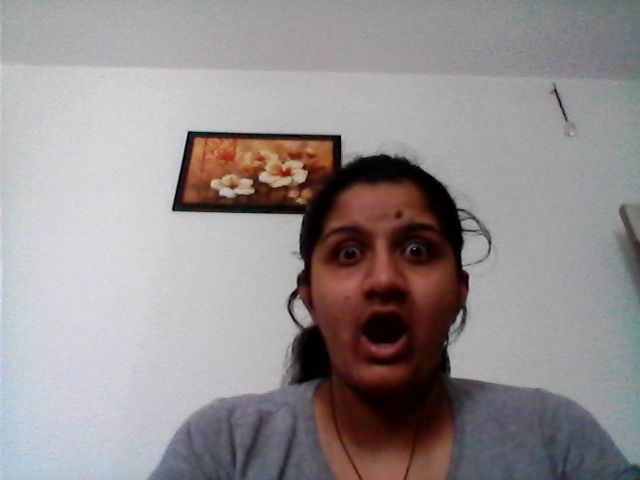

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

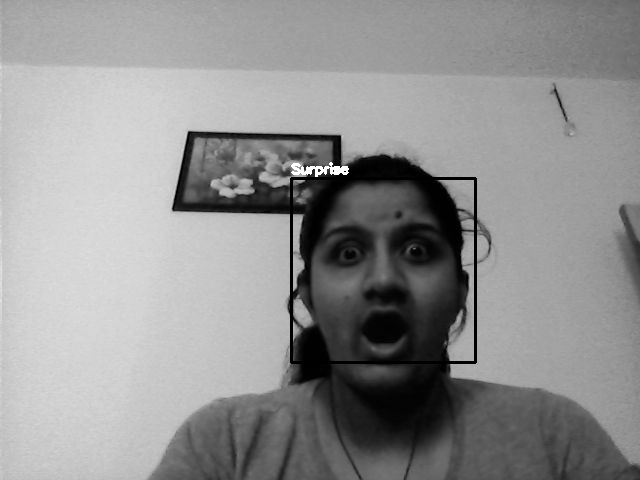

Surprise


In [ ]:
# webcam
from google.colab.patches import cv2_imshow
import copy

image = cv2.imread('/content/photo.jpg')

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
faces = face_cascade.detectMultiScale(gray)

for (x,y,w,h) in faces:
  fc = gray[y:y+h, x:x+w]
 
  roi = cv2.resize(fc, (48,48))
  pred = loaded_model.predict(roi[np.newaxis, :, :, np.newaxis])
  text_idx=np.argmax(pred)
  text_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
  if text_idx == 0:
    text= text_list[0]
  if text_idx == 1:
    text= text_list[1]
  elif text_idx == 2:
    text= text_list[2]
  elif text_idx == 3:
    text= text_list[3]
  elif text_idx == 4:
    text= text_list[4]
  elif text_idx == 5:
    text= text_list[5]
  elif text_idx == 6:
    text= text_list[6]
  
  cv2.putText(gray, text, (x, y-5),
  cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 255), 2)
  img2 = cv2.rectangle(gray, (x,y), (x+w, y+h), (0,0,255), 2)
            
    
cv2_imshow(img2)
print(text)
    
cap.release()
cv2.destroyAllWindows()

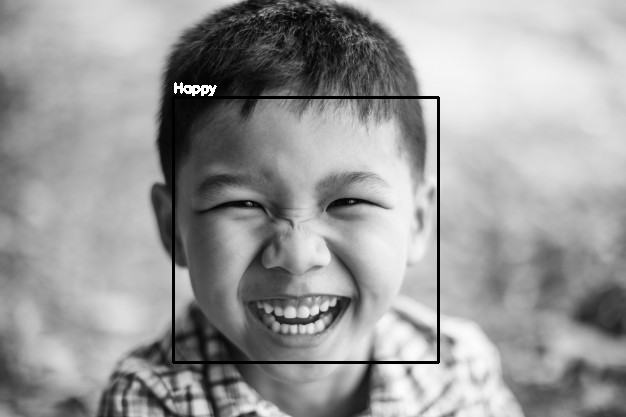

Happy


In [ ]:
# happy

from google.colab.patches import cv2_imshow
import copy

image = cv2.imread('/content/happy.jpg')

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
faces = face_cascade.detectMultiScale(gray)

for (x,y,w,h) in faces:
  fc = gray[y:y+h, x:x+w]
 
  roi = cv2.resize(fc, (48,48))
  pred = loaded_model.predict(roi[np.newaxis, :, :, np.newaxis])
  text_idx=np.argmax(pred)
  text_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
  if text_idx == 0:
    text= text_list[0]
  if text_idx == 1:
    text= text_list[1]
  elif text_idx == 2:
    text= text_list[2]
  elif text_idx == 3:
    text= text_list[3]
  elif text_idx == 4:
    text= text_list[4]
  elif text_idx == 5:
    text= text_list[5]
  elif text_idx == 6:
    text= text_list[6]
  
  cv2.putText(gray, text, (x, y-5),
  cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 255), 2)
  img2 = cv2.rectangle(gray, (x,y), (x+w, y+h), (0,0,255), 2)
            
    
cv2_imshow(img2)
print(text)
    
cap.release()
cv2.destroyAllWindows()

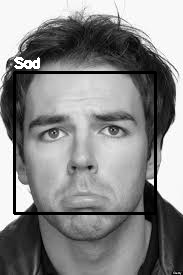

Sad


In [ ]:
# sad
from google.colab.patches import cv2_imshow
import copy

image = cv2.imread('/content/sad.jpg')

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
faces = face_cascade.detectMultiScale(gray)

for (x,y,w,h) in faces:
  fc = gray[y:y+h, x:x+w]
 
  roi = cv2.resize(fc, (48,48))
  pred = loaded_model.predict(roi[np.newaxis, :, :, np.newaxis])
  text_idx=np.argmax(pred)
  text_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
  if text_idx == 0:
    text= text_list[0]
  if text_idx == 1:
    text= text_list[1]
  elif text_idx == 2:
    text= text_list[2]
  elif text_idx == 3:
    text= text_list[3]
  elif text_idx == 4:
    text= text_list[4]
  elif text_idx == 5:
    text= text_list[5]
  elif text_idx == 6:
    text= text_list[6]
  
  cv2.putText(gray, text, (x, y-5),
  cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 255), 2)
  img2 = cv2.rectangle(gray, (x,y), (x+w, y+h), (0,0,255), 2)
            
    
cv2_imshow(img2)
print(text)
    
cap.release()
cv2.destroyAllWindows()

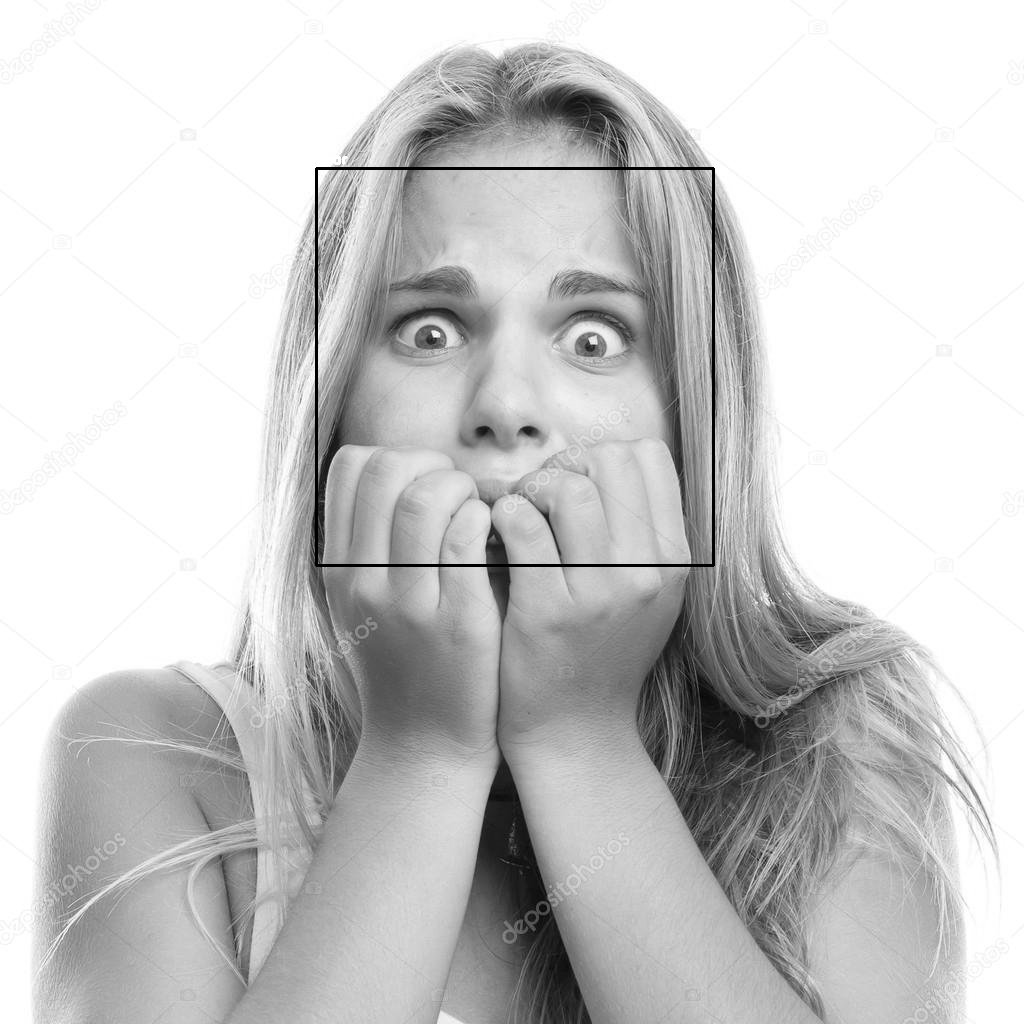

Fear


In [ ]:
# fear
from google.colab.patches import cv2_imshow
import copy

image = cv2.imread('/content/fear.jpg')

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
faces = face_cascade.detectMultiScale(gray)

for (x,y,w,h) in faces:
  fc = gray[y:y+h, x:x+w]
 
  roi = cv2.resize(fc, (48,48))
  pred = loaded_model.predict(roi[np.newaxis, :, :, np.newaxis])
  text_idx=np.argmax(pred)
  text_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
  if text_idx == 0:
    text= text_list[0]
  if text_idx == 1:
    text= text_list[1]
  elif text_idx == 2:
    text= text_list[2]
  elif text_idx == 3:
    text= text_list[3]
  elif text_idx == 4:
    text= text_list[4]
  elif text_idx == 5:
    text= text_list[5]
  elif text_idx == 6:
    text= text_list[6]
  
  cv2.putText(gray, text, (x, y-5),
  cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 255), 2)
  img2 = cv2.rectangle(gray, (x,y), (x+w, y+h), (0,0,255), 2)
            
    
cv2_imshow(img2)
print(text)
    
cap.release()
cv2.destroyAllWindows()

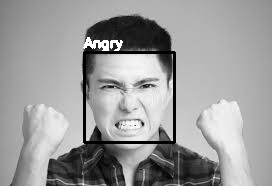

Angry


In [ ]:
# angry
from google.colab.patches import cv2_imshow
import copy

image = cv2.imread('/content/angry.jpeg')

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
faces = face_cascade.detectMultiScale(gray)

for (x,y,w,h) in faces:
  fc = gray[y:y+h, x:x+w]
 
  roi = cv2.resize(fc, (48,48))
  pred = loaded_model.predict(roi[np.newaxis, :, :, np.newaxis])
  text_idx=np.argmax(pred)
  text_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
  if text_idx == 0:
    text= text_list[0]
  if text_idx == 1:
    text= text_list[1]
  elif text_idx == 2:
    text= text_list[2]
  elif text_idx == 3:
    text= text_list[3]
  elif text_idx == 4:
    text= text_list[4]
  elif text_idx == 5:
    text= text_list[5]
  elif text_idx == 6:
    text= text_list[6]
  
  cv2.putText(gray, text, (x, y-5),
  cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 255), 2)
  img2 = cv2.rectangle(gray, (x,y), (x+w, y+h), (0,0,255), 2)
            
    
cv2_imshow(img2)
print(text)
    
cap.release()
cv2.destroyAllWindows()

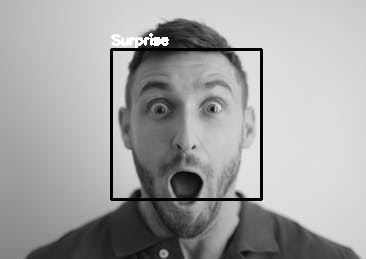

Surprise


In [ ]:
# surprise
from google.colab.patches import cv2_imshow
import copy

image = cv2.imread('/content/surprise.jpeg')

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
faces = face_cascade.detectMultiScale(gray)

for (x,y,w,h) in faces:
  fc = gray[y:y+h, x:x+w]
 
  roi = cv2.resize(fc, (48,48))
  pred = loaded_model.predict(roi[np.newaxis, :, :, np.newaxis])
  text_idx=np.argmax(pred)
  text_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
  if text_idx == 0:
    text= text_list[0]
  if text_idx == 1:
    text= text_list[1]
  elif text_idx == 2:
    text= text_list[2]
  elif text_idx == 3:
    text= text_list[3]
  elif text_idx == 4:
    text= text_list[4]
  elif text_idx == 5:
    text= text_list[5]
  elif text_idx == 6:
    text= text_list[6]
  
  cv2.putText(gray, text, (x, y-5),
  cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 255), 2)
  img2 = cv2.rectangle(gray, (x,y), (x+w, y+h), (0,0,255), 2)
            
    
cv2_imshow(img2)
print(text)
    
cap.release()
cv2.destroyAllWindows()

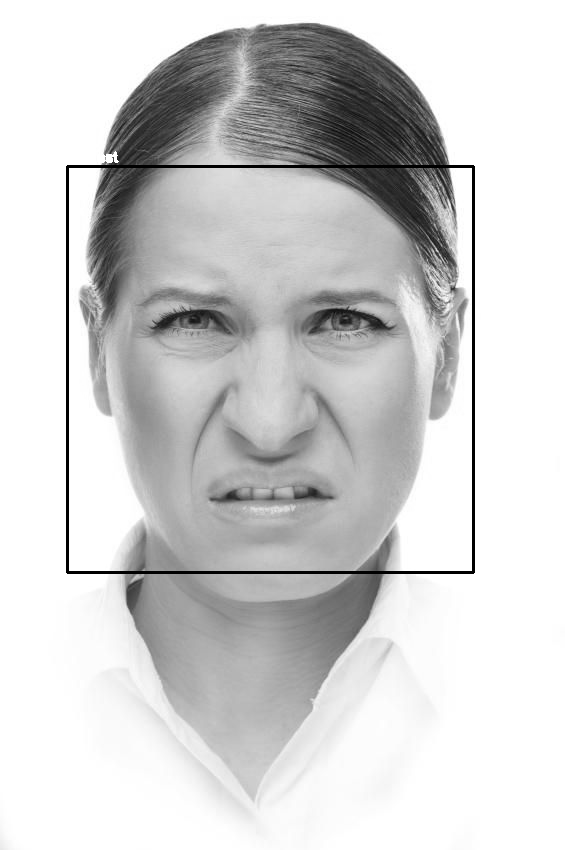

Disgust


In [ ]:
# disgust
from google.colab.patches import cv2_imshow
import copy

image = cv2.imread('/content/disgust.jpg')

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
faces = face_cascade.detectMultiScale(gray)

for (x,y,w,h) in faces:
  fc = gray[y:y+h, x:x+w]
 
  roi = cv2.resize(fc, (48,48))
  pred = loaded_model.predict(roi[np.newaxis, :, :, np.newaxis])
  text_idx=np.argmax(pred)
  text_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
  if text_idx == 0:
    text= text_list[0]
  if text_idx == 1:
    text= text_list[1]
  elif text_idx == 2:
    text= text_list[2]
  elif text_idx == 3:
    text= text_list[3]
  elif text_idx == 4:
    text= text_list[4]
  elif text_idx == 5:
    text= text_list[5]
  elif text_idx == 6:
    text= text_list[6]
  
  cv2.putText(gray, text, (x, y-5),
  cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 255), 2)
  img2 = cv2.rectangle(gray, (x,y), (x+w, y+h), (0,0,255), 2)
            
    
cv2_imshow(img2)
print(text)
    
cap.release()
cv2.destroyAllWindows()

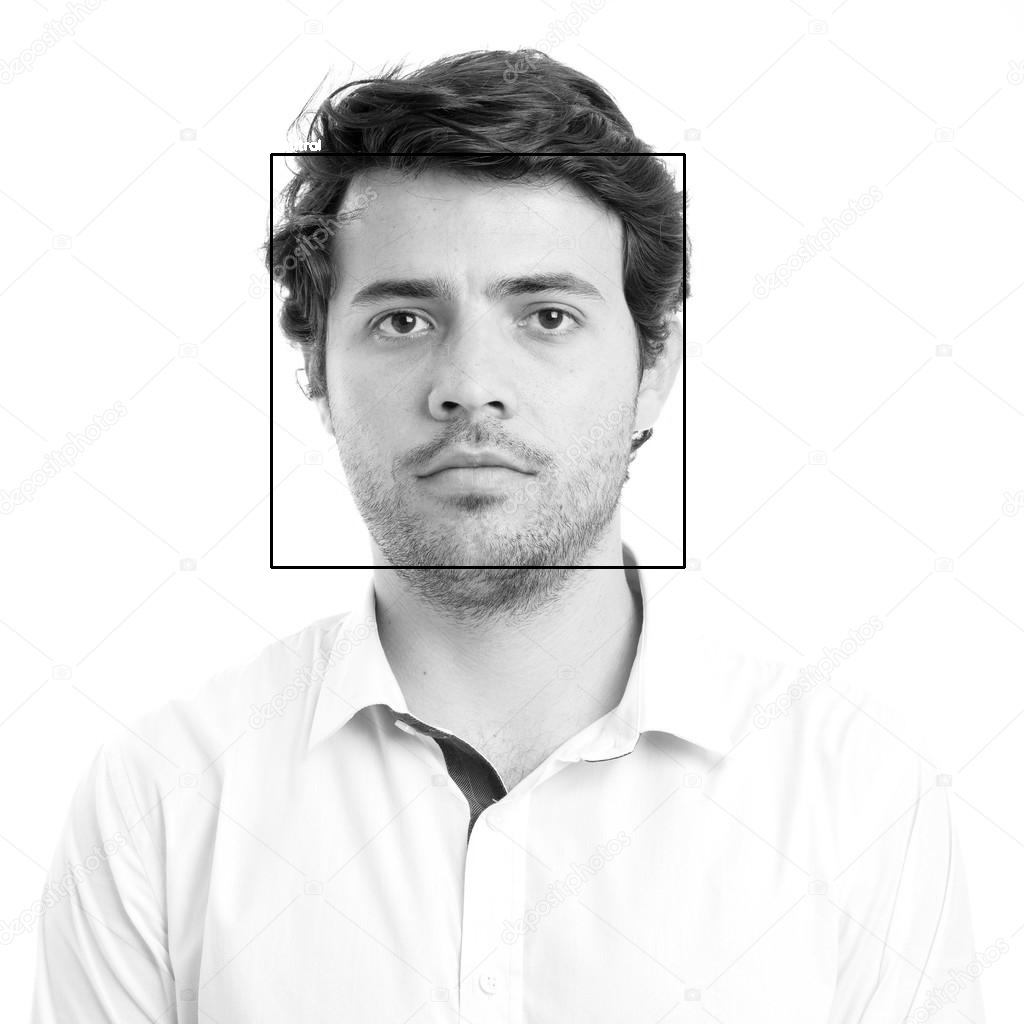

Neutral


In [ ]:
# neutral
from google.colab.patches import cv2_imshow
import copy

image = cv2.imread('/content/neutral.jpg')

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
faces = face_cascade.detectMultiScale(gray)

for (x,y,w,h) in faces:
  fc = gray[y:y+h, x:x+w]
 
  roi = cv2.resize(fc, (48,48))
  pred = loaded_model.predict(roi[np.newaxis, :, :, np.newaxis])
  text_idx=np.argmax(pred)
  text_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
  if text_idx == 0:
    text= text_list[0]
  if text_idx == 1:
    text= text_list[1]
  elif text_idx == 2:
    text= text_list[2]
  elif text_idx == 3:
    text= text_list[3]
  elif text_idx == 4:
    text= text_list[4]
  elif text_idx == 5:
    text= text_list[5]
  elif text_idx == 6:
    text= text_list[6]
  
  cv2.putText(gray, text, (x, y-5),
  cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 255), 2)
  img2 = cv2.rectangle(gray, (x,y), (x+w, y+h), (0,0,255), 2)
            
    
cv2_imshow(img2)
print(text)
    
cap.release()
cv2.destroyAllWindows()